
## Phase 1 - Lane Line detection

                                                  Project Contributors
| Student Name    |      Code     |  
|----------|:-------------:|
| Hassan Mohsen Hassan Ahmed |  16T0180 | 
| Ahmed Abdallah Abdallah Selim |  12IC004 |
| Ahmed Nabih Belyas Abdel Zaher  | 11T0029 | 



This notebook provides a robust solution to lane line detection .The steps are as listed:

1. Camera Calibration  
2. Distortion Correction   
3. Gradient and Color Thresholding   
4. Perspective Transform   
5. Lane Line finding & Search Optimization
6. Drawing the lane on image

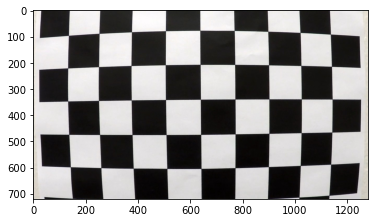

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Make a list of calibration images
img = mpimg.imread('camera_cal/calibration1.jpg')
plt.imshow(img)
   

## Camera calibration

In the following code camera calibration is performed. The code is based on [Udacity's](https://github.com/udacity/CarND-Camera-Calibration/blob/master/camera_calibration.ipynb) example.

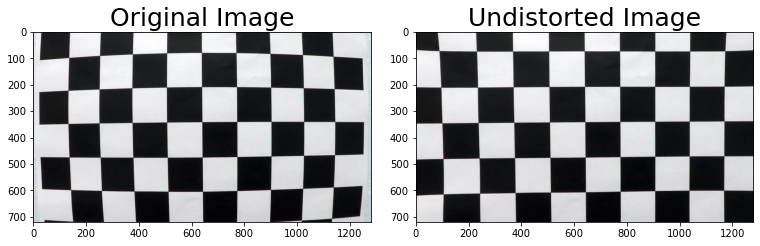

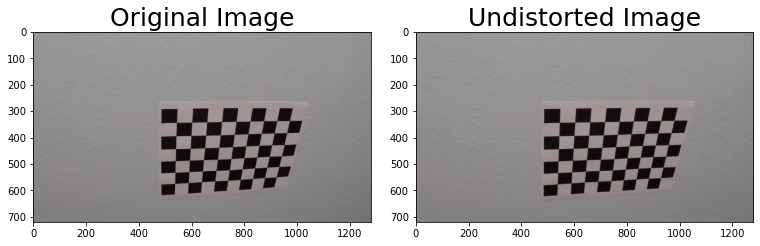

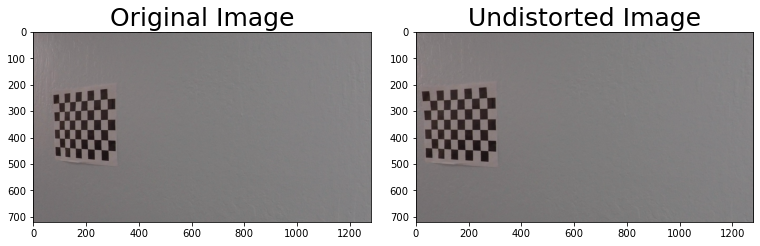

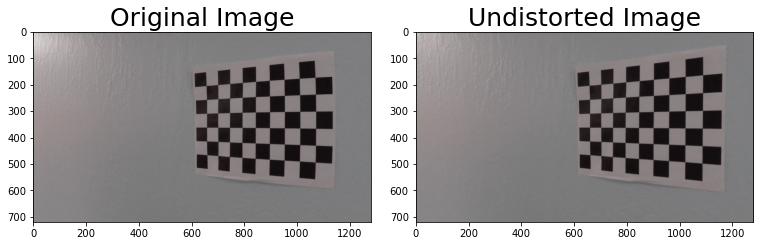

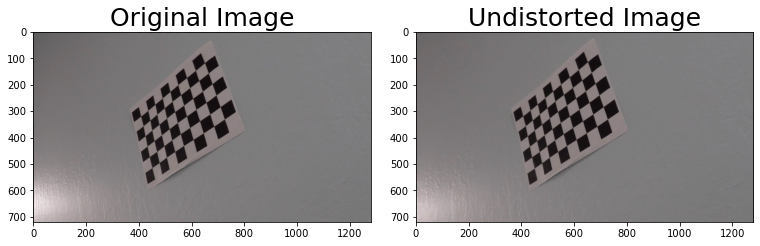

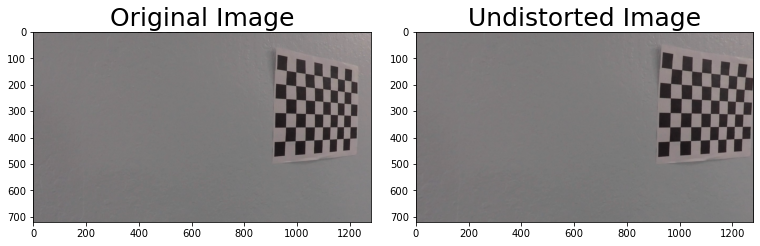

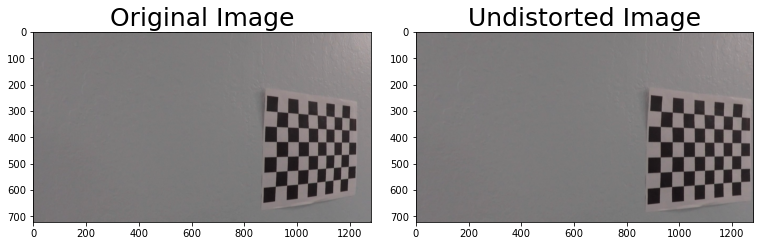

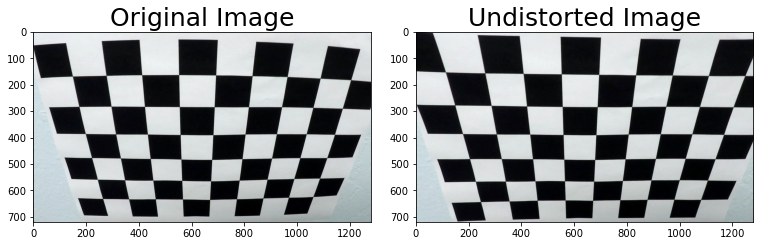

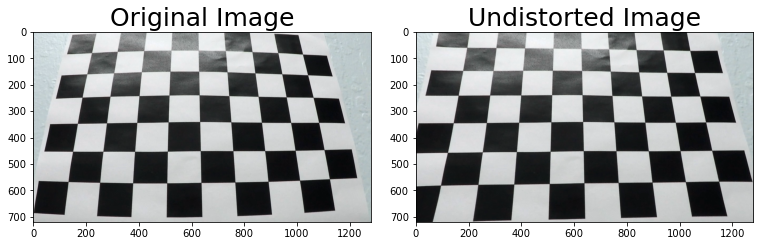

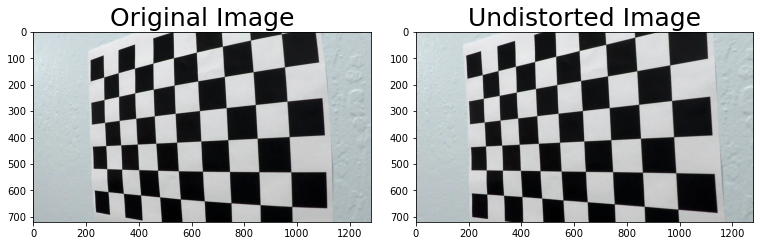

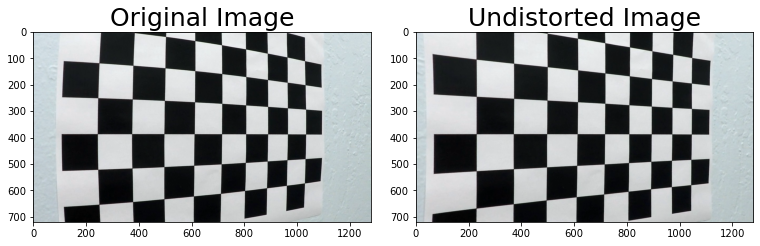

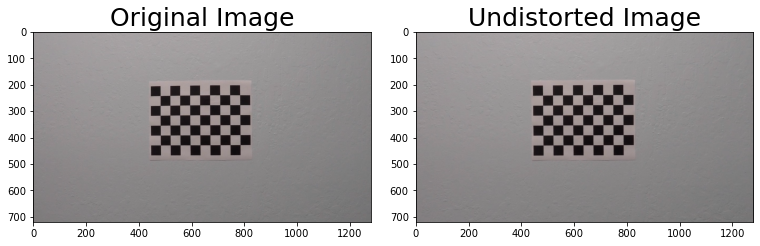

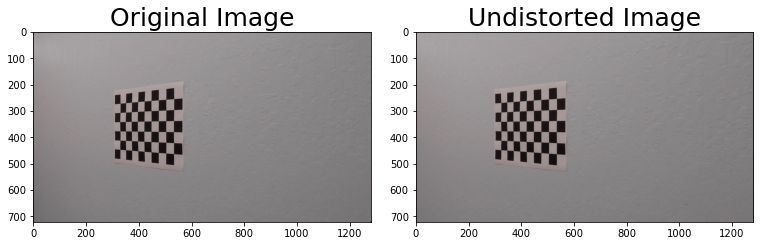

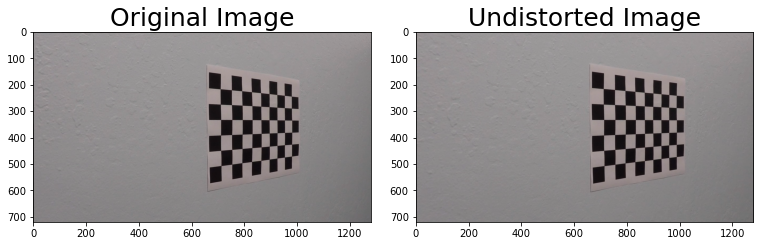

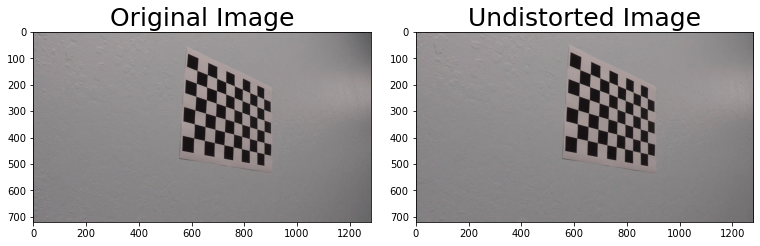

In [2]:
import glob

# Read in and make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
#Arrays to store object points and image points from all the images

objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# Prepare object points, like (0,0,0), (1,0,0), .....(7,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x, y coordinate

for fname in images:
    #read in each image
    img = cv2.imread(fname)
    
    #convert image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    #Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    #if corners are found, add object points, image points

    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
# Calibrate camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
for fname in images:
    img = cv2.imread(fname)
    undistort_img = cv2.undistort(img, mtx, dist, None, mtx)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=25)
    ax2.imshow(undistort_img)
    ax2.set_title('Undistorted Image', fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

['./test_images\\straight_lines1.jpg', './test_images\\straight_lines2.jpg', './test_images\\test1.jpg', './test_images\\test2.jpg', './test_images\\test3.jpg', './test_images\\test4.jpg', './test_images\\test5.jpg', './test_images\\test6.jpg']


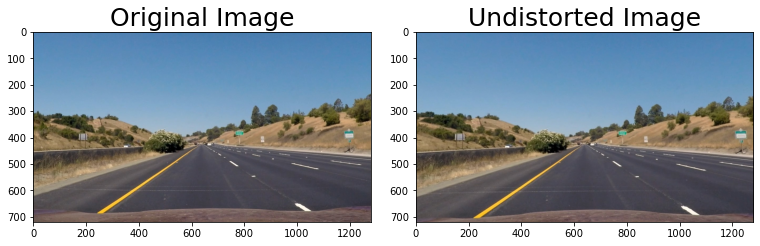

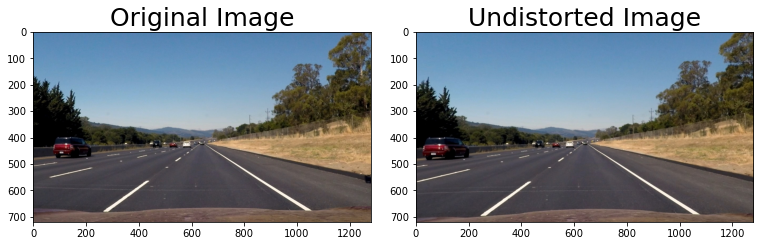

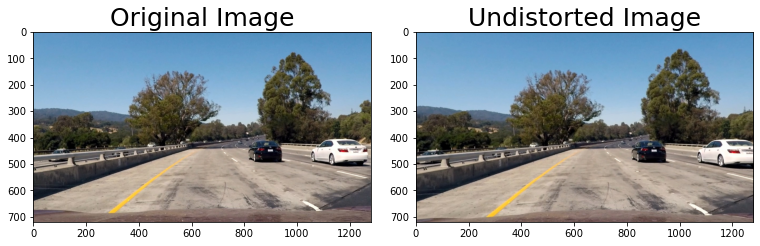

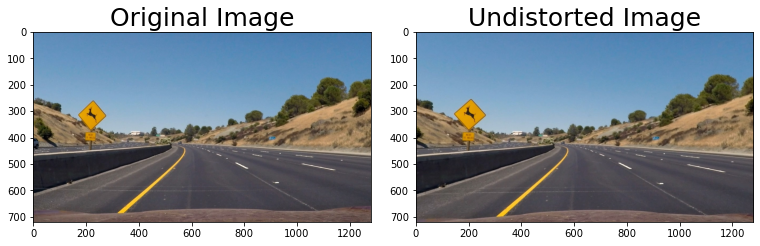

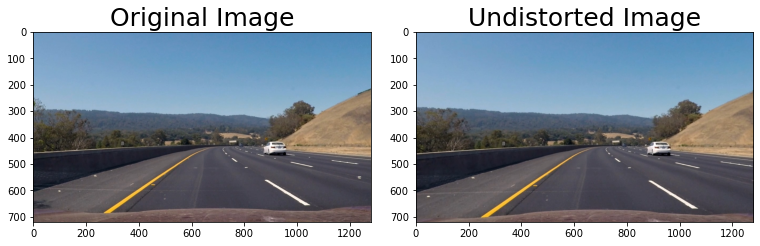

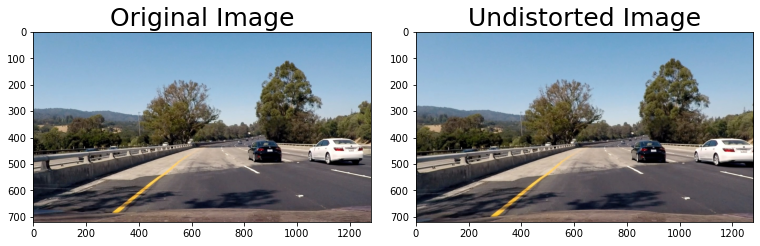

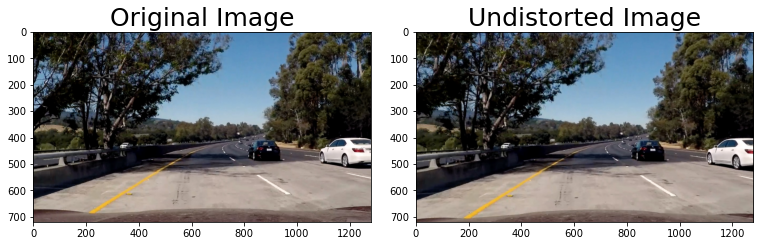

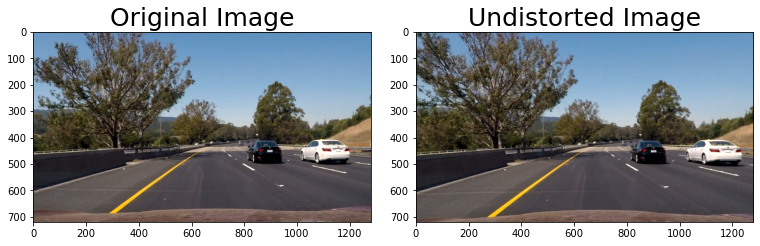

In [3]:
undist_images = []

images = glob.glob('./test_images/*.jpg')
print (images)
for fname in images:
    img = mpimg.imread(fname)
    undistort_img = cv2.undistort(img, mtx, dist, None, mtx)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=25)
    ax2.imshow(undistort_img)
    ax2.set_title('Undistorted Image', fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    undist_images.append(undistort_img)

# Gradient & Color Thresholding
For this project we will be using several filters to generate a binary (black & white) image that we can detect and track the lane lines with. 

* Sobel gradients in the x & y directions
* Gradient magnitude
* Gradient direction
* Color space transform and filtering

## Define a function to return the magnitude of the gradient


In [4]:
def abs_sobel(img, sobel_kernel=3):
    '''Apply Sobel operator to an image and return absolute value of sobel value on x and y direction'''
    if img.ndim == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    return abs_sobel_x, abs_sobel_y

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    '''Calculate sobel x and y and filter result'''
    abs_sobel_x, abs_sobel_y = abs_sobel(img, sobel_kernel)
    if orient == 'x':
        sobel = abs_sobel_x
    if orient == 'y':
        sobel = abs_sobel_y
    scaled_sobel = np.uint8(255 * sobel / np.max(sobel))
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    '''Calculate gradient magnitude and filter result'''
    abs_sobel_x, abs_sobel_y = abs_sobel(img, sobel_kernel)
    gradmag = np.sqrt(abs_sobel_x**2 + abs_sobel_y**2)
    scaled_gradmag = np.uint8(255 * gradmag / np.max(gradmag))
    mag_binary = np.zeros_like(scaled_gradmag)
    mag_binary[(scaled_gradmag >= mag_thresh[0]) & (scaled_gradmag <= mag_thresh[1])] = 1
    return mag_binary

def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    '''Calculate gradient direction and filter result'''
    abs_sobel_x, abs_sobel_y = abs_sobel(img, sobel_kernel)
    graddir = np.arctan2(abs_sobel_y, abs_sobel_x)
    dir_binary = np.zeros_like(graddir)
    dir_binary[(graddir >= thresh[0]) & (graddir <= thresh[1])] = 1
    return dir_binary

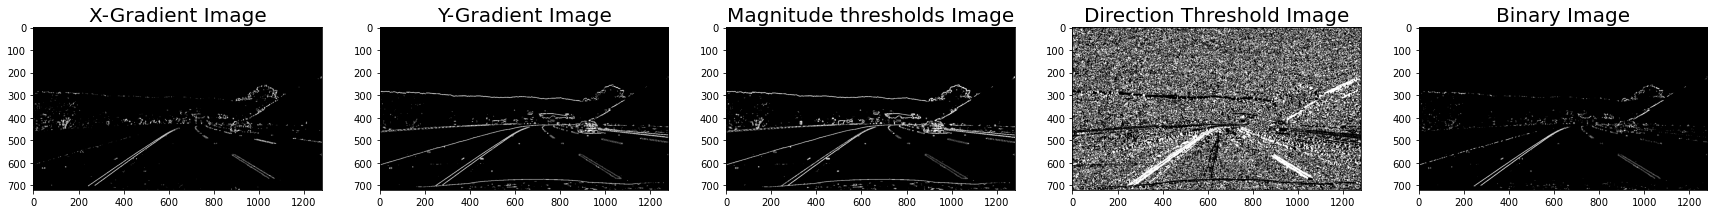

In [5]:
img = undist_images[4]

gradx = abs_sobel_thresh(img, 'x', sobel_kernel=3, thresh=(30, 100))

grady = abs_sobel_thresh(img, 'y', sobel_kernel=3, thresh=(30, 100))

# filter magnitude
mag_binary = mag_thresh(img, mag_thresh=(30, 100))

# filter direction
dir_binary = dir_thresh(img, sobel_kernel=15, thresh=(0.7, 1.3))

binary = np.zeros_like(gradx)
binary[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(30,10))
ax1.set_title('X-Gradient Image', fontsize=20)
ax1.imshow(gradx, cmap='gray')

ax2.set_title('Y-Gradient Image', fontsize=20)
ax2.imshow(grady, cmap='gray')
    
ax3.set_title('Magnitude thresholds Image', fontsize=20)
ax3.imshow(mag_binary, cmap='gray')

ax4.set_title('Direction Threshold Image', fontsize=20)
ax4.imshow(dir_binary, cmap='gray')

ax5.set_title('Binary Image', fontsize=20)
ax5.imshow(binary, cmap='gray')



## Color Thresholding

In [6]:
def lab_thresh(img, l_yellow, h_yellow, l_white, h_white):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    yellow = cv2.inRange(lab, l_yellow, h_yellow)
    white = cv2.inRange(lab, l_white, h_white)
    mask = cv2.bitwise_or(yellow, white)
    res = cv2.bitwise_and(img, img, mask=mask)
    return mask, res

def color_thresh(img):
    lower_yellow = np.array([0, 0 , 80])
    upper_yellow = np.array([255, 255, 110])
    lower_white = np.array([196, 0, 0])
    upper_white = np.array([255, 255, 255])
    mask, lab = lab_thresh(img, lower_yellow, upper_yellow, lower_white, upper_white)
    return mask, lab

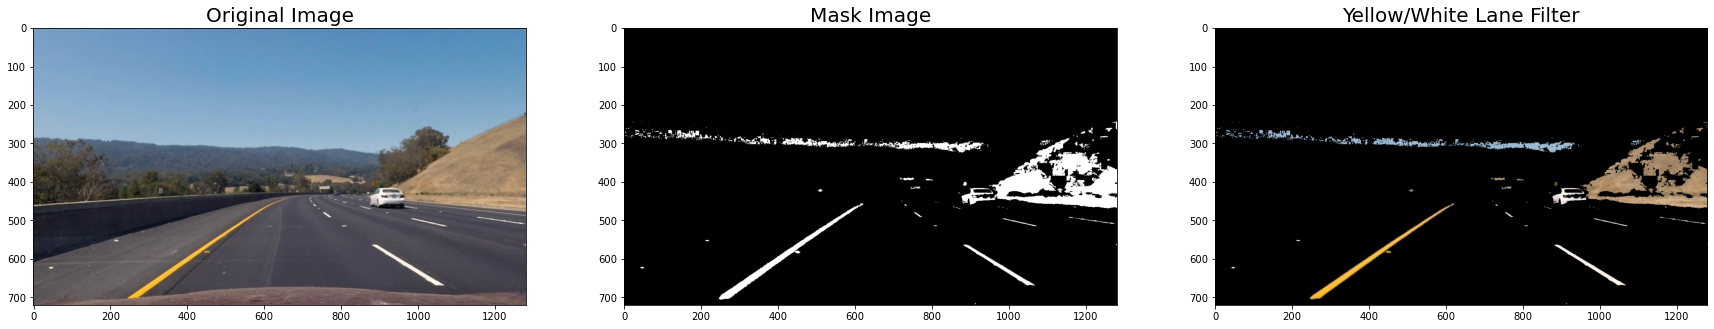

In [7]:
img = undist_images[4]
mask, lab = color_thresh(img)


f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.set_title('Original Image', fontsize=20)
ax1.imshow(img)

ax2.set_title('Mask Image', fontsize=20)
ax2.imshow(mask, cmap='gray')
    
ax3.set_title('Yellow/White Lane Filter', fontsize=20)
ax3.imshow(lab, cmap='gray')



# Combining Gradient Threshold and Color specs

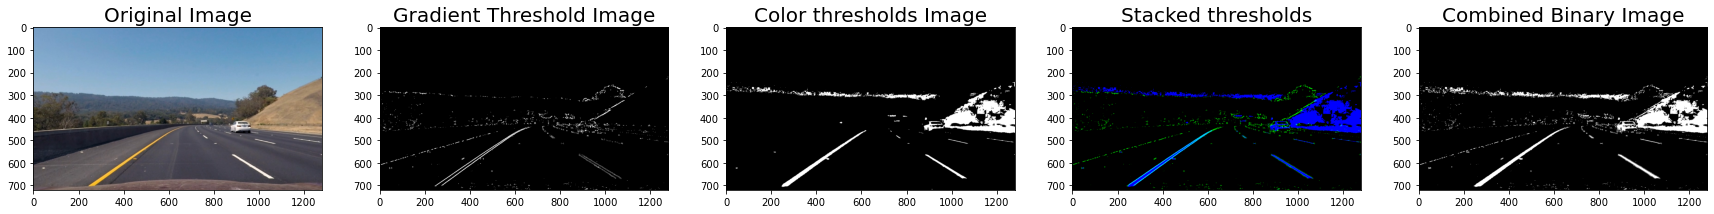

In [8]:
img = undist_images[4]

# gradient method
gradx = abs_sobel_thresh(img, 'x', sobel_kernel=3, thresh=(30, 100))
grady = abs_sobel_thresh(img, 'y', sobel_kernel=3, thresh=(30, 100))
mag_binary = mag_thresh(img, mag_thresh=(30, 100))
dir_binary = dir_thresh(img, sobel_kernel=15, thresh=(0.7, 1.3))

grad = np.zeros_like(gradx)
grad[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Color selection
color,res = color_thresh(img)

# Combine
stack_binary = np.dstack((np.zeros_like(grad), grad*255, color))

Combined_Binary = np.zeros_like(gradx)
Combined_Binary[(grad == 1) | (color == 255)] = 1

f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(30,10))
ax1.set_title('Original Image', fontsize=20)
ax1.imshow(img, cmap='gray')

ax2.set_title('Gradient Threshold Image', fontsize=20)
ax2.imshow(grad, cmap='gray')
    
ax3.set_title('Color thresholds Image', fontsize=20)
ax3.imshow(color, cmap='gray')

ax4.set_title('Stacked thresholds', fontsize=20)
ax4.imshow(stack_binary, cmap='gray')

ax5.set_title('Combined Binary Image', fontsize=20)
ax5.imshow(Combined_Binary, cmap='gray')


# 3. Perspective Transform

After we get a binary image that contains lane lines, we will perform a perspective transform to the image and it will be rectified to a "warp_images".

A straight road is choosed to verify the transformation.

(1280, 720)


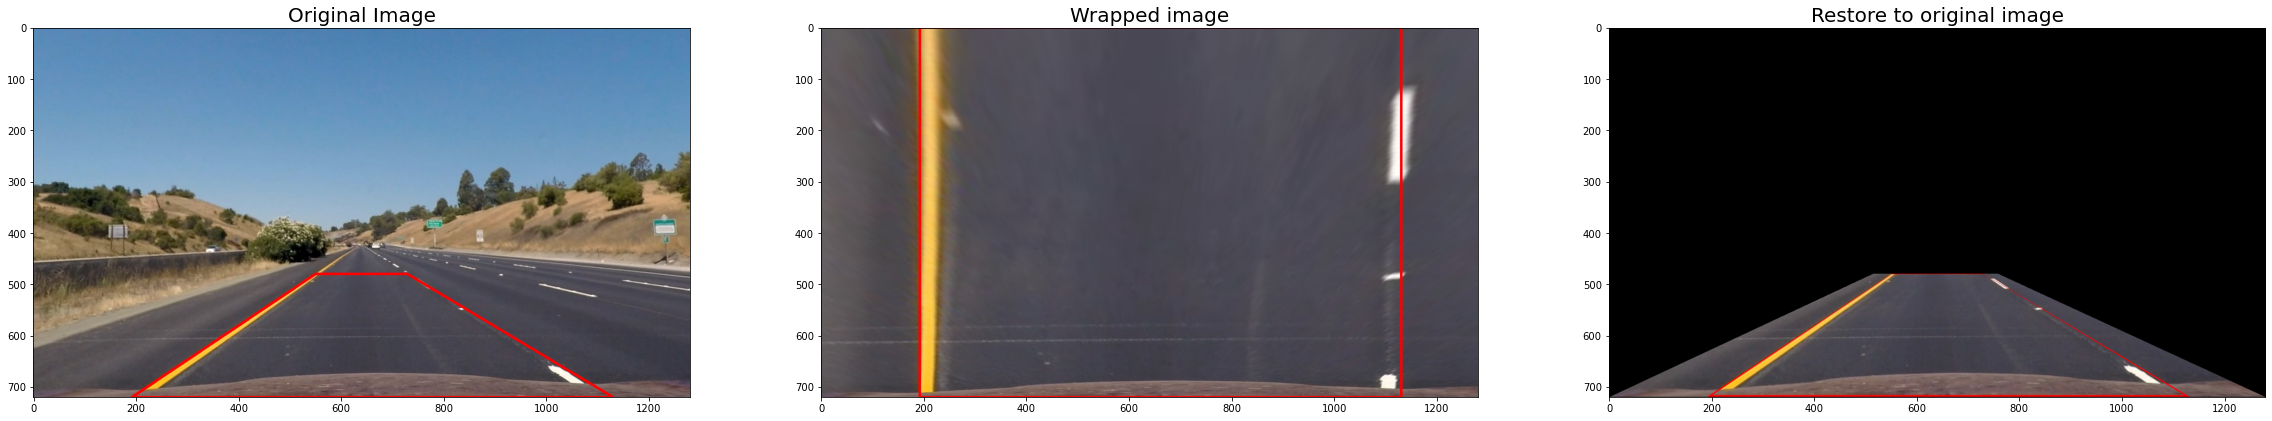

In [9]:
img = undist_images[0]

copy = np.copy(img)
image_size = (img.shape[1], img.shape[0])
print(image_size)
xLen = copy.shape[1]
yLen = copy.shape[0]
src = np.float32([[0.15*xLen, yLen], [(0.5 * xLen) - (xLen*0.07), (2/3)*yLen], [(0.5 * xLen) + (xLen*0.07), (2/3)*yLen], [xLen-150, yLen]])
    
dst = np.float32([[0.15*xLen, yLen], [0.15*xLen, 0], [xLen-150, 0], [xLen-150, yLen]])


lines_o = cv2.polylines(copy, np.int32([src]), True, (255, 0, 0), 3)

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
image_size = (img.shape[1], img.shape[0])
warped = cv2.warpPerspective(img, M, image_size, cv2.INTER_LINEAR)

# Draw lines
lines_w = cv2.polylines(warped, np.int32([dst]), True, (255, 0, 0), 3)


# Restore to original image
restore_img = cv2.warpPerspective(warped, Minv, image_size, cv2.INTER_LINEAR)

# Plotting Wrapped images
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(40,20))

ax1.set_title('Original Image', fontsize=20)
ax1.imshow(lines_o)

ax2.set_title('Wrapped image', fontsize=20)
ax2.imshow(lines_w)

ax3.set_title('Restore to original image', fontsize=20)
ax3.imshow(restore_img)


In [10]:
def combined_binary(img):
    # gradient method
    gradx = abs_sobel_thresh(img, 'x', sobel_kernel=3, thresh=(30, 100))
    grady = abs_sobel_thresh(img, 'y', sobel_kernel=3, thresh=(30, 100))
    mag_binary = mag_thresh(img, mag_thresh=(30, 100))
    dir_binary = dir_thresh(img, sobel_kernel=15, thresh=(0.7, 1.3))
    
    grad = np.zeros_like(gradx)
    grad[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    color, res = color_thresh(img)

    # Combine two methods
    binary_img = np.zeros_like(gradx)
    binary_img[(grad == 1) | (color == 255)] = 1
    #binary_img[(color == 255)] = 1
    return binary_img

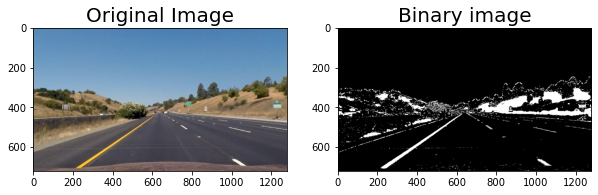

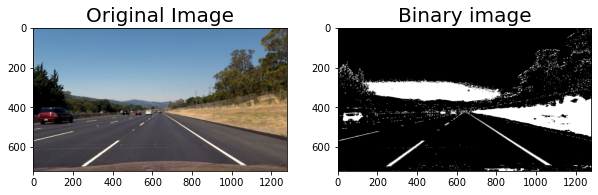

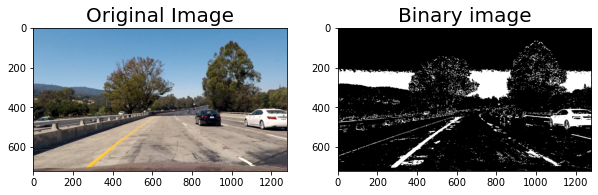

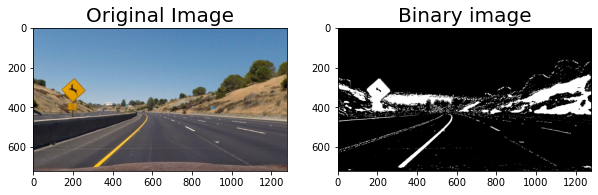

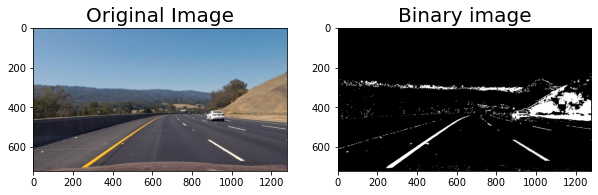

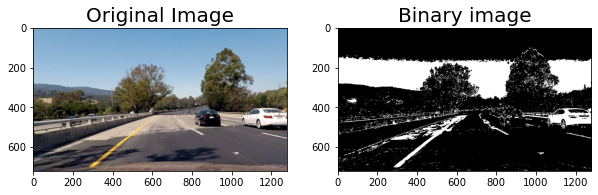

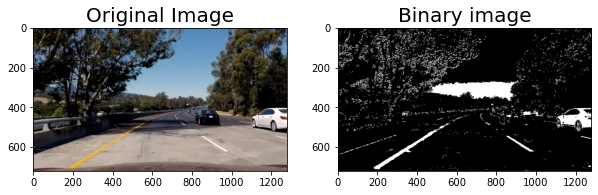

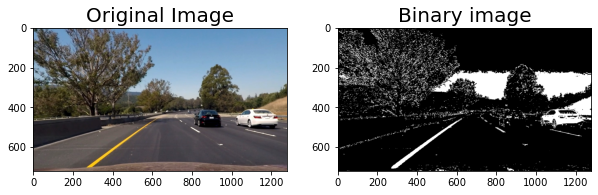

In [11]:
binary_images = []
for img in undist_images:
    binary_image = combined_binary(img)
    binary_images.append(binary_image)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

    ax1.set_title('Original Image', fontsize=20)
    ax1.imshow(img)

    ax2.set_title('Binary image', fontsize=20)
    ax2.imshow(binary_image, cmap='gray')



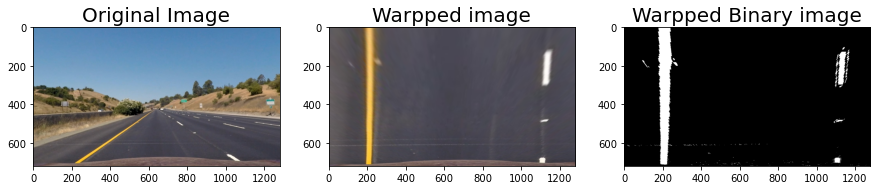

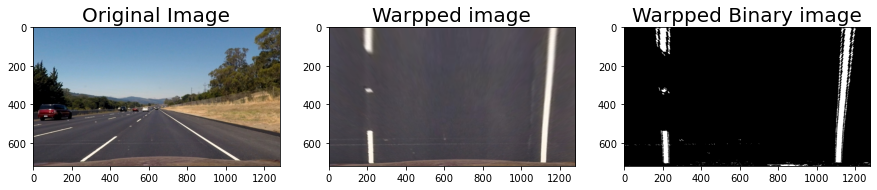

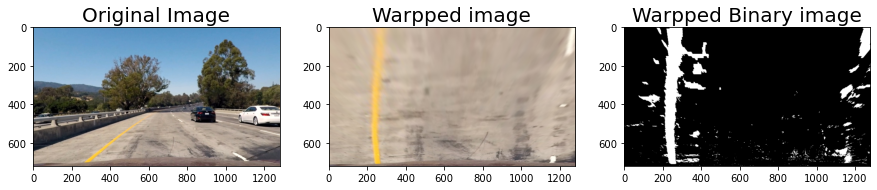

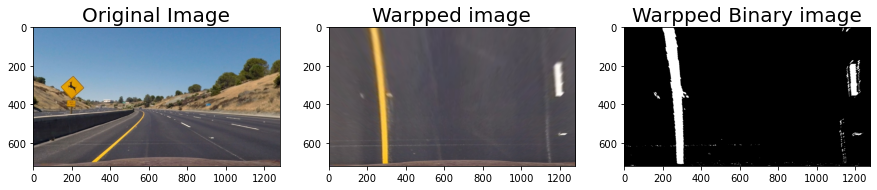

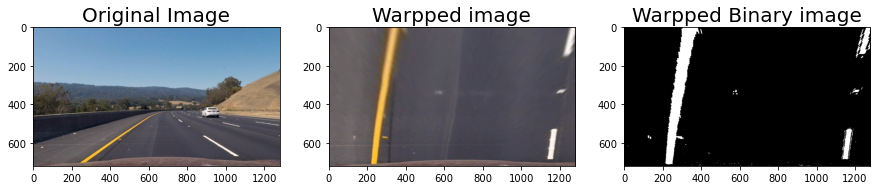

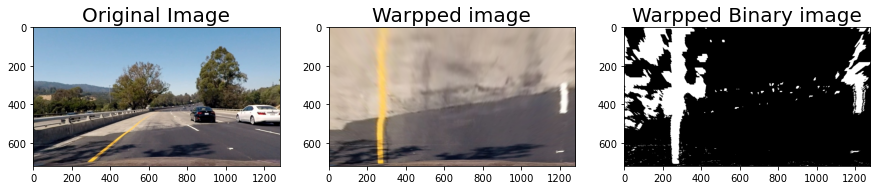

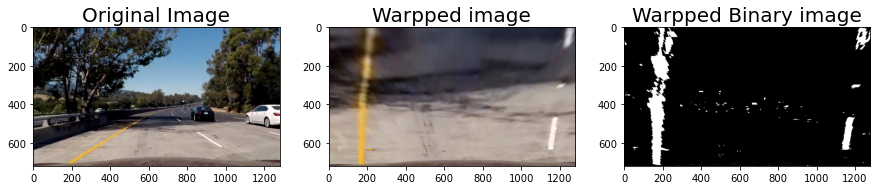

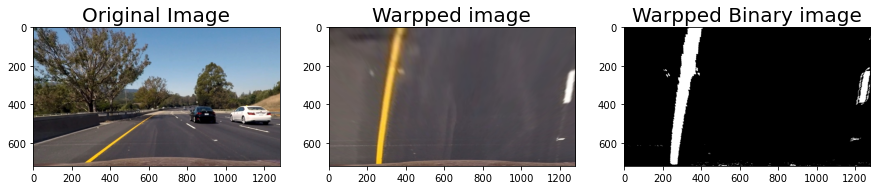

In [12]:
warp_images = []
warp_binary_images = []
for i in range(len(undist_images)):
    image = undist_images[i]
    image_size = (image.shape[1], image.shape[0])
    warped = cv2.warpPerspective(image, M, image_size, cv2.INTER_LINEAR)
    warp_images.append(warped)
    
    binary_image = binary_images[i]
    binary_warped = cv2.warpPerspective(binary_image, M, image_size, cv2.INTER_LINEAR)
    warp_binary_images.append(binary_warped)
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,6))

    ax1.set_title('Original Image', fontsize=20)
    ax1.imshow(image)

    ax2.set_title('Warpped image', fontsize=20)
    ax2.imshow(warped)

    ax3.set_title('Warpped Binary image', fontsize=20)
    ax3.imshow(binary_warped, cmap='gray')
    


# 4. Find Lane pixels and measure curvature



In [13]:
"""
Draw a polynomial line on an image
"""
def draw_polyline(img, fit):
    y = np.linspace(0, img.shape[0]-1, img.shape[0])
    x = fit[0] * y**2 + fit[1] * y + fit[2]
    pts = np.array([np.transpose(np.vstack([x, y]))])
    cv2.polylines(img, np.int_(pts), isClosed=False, color=(255,255,0), thickness=3)
    return img

In [14]:
"""
Sliding window search method. It's used to locate lane pixels from scratch, given no previous information.
Input: a binary image with birds' eye view.
Ouput: left and right fitted x,y and a diagnosis image.
"""
def sliding_win_search(binary_warped, nwindows=9, margin=50, minpix=50):
    # A diagnosis image
    diag_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Get the histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(diag_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(diag_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Highlight lane pixels and draw fit polynomials
    diag_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    diag_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    draw_polyline(diag_img, left_fit)
    draw_polyline(diag_img, right_fit)
    
    return left_fit, right_fit, diag_img

In [15]:
"""
Draw search region (Region of Interest) on an image
"""
def draw_roi(img, fit, margin):
    window_img = np.zeros_like(img)
    
    # Generate x and y values for plotting
    y = np.linspace(0, img.shape[0]-1, img.shape[0])
    x = fit[0] * y**2 + fit[1] * y + fit[2]
    
    line_window1 = np.array([np.transpose(np.vstack([x-margin, y]))])
    line_window2 = np.array([np.flipud(np.transpose(np.vstack([x+margin, y])))])
    line_pts = np.hstack((line_window1, line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([line_pts]), (0,255, 0))
    result = cv2.addWeighted(img, 1, window_img, 0.3, 0)
    return result

In [16]:
"""
Search lane pixels within a polynomial ROI given the previous left and right lane polynomial function.
Input: a binary image from birds' eye view, left lane and right lane polynomial function.
Output: fitted left/right lane lines, a diagnosis image.
"""
def search_roi(binary_warped, left_fit, right_fit, margin=50):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_center = left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2]
    left_lane_inds = ((nonzerox > (left_center - margin)) & (nonzerox < (left_center + margin))) 
    right_center = right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2]
    right_lane_inds = ((nonzerox > (right_center - margin)) & (nonzerox < (right_center + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    #------------- VISUALIZE THE OUTPUT ------------------

    # Create an image to draw on and an image to show the selection window
    diag_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Color in left and right line pixels
    diag_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    diag_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Illustrate the search window area
    diag_img = draw_roi(diag_img, left_fit, margin)  
    diag_img = draw_roi(diag_img, right_fit, margin)
    draw_polyline(diag_img, left_fit)
    draw_polyline(diag_img, right_fit)
    return left_fit, right_fit, diag_img

# Determine the lane curvature

Now that we have the lanes, we will want to compute the radius of the curvature (i.e. how much the road is curving). This information will be critical later in the end-to-end learning process when we need to create programs that will govern the steering and acceleration of the car. The most important step in this process will be converting our measurements from pixel space to the metric system. The formula for radius of curvature is given as:

$$R_{curve}=\frac{[1+(\frac{dx}{dy})^2]^\frac{3}{2}}{|\frac{d^2x}{dy^2}|}$$

Where the second order polynomial $f(y)$ is defined as:

$$f(y)=Ay^2+By+C$$

Notice that it is $f(y)$ *not* $f(x)$. This is because in the lane lane, there may be more than one $y$ value for any given $x$.The first and second derivatives of $f(y)$ are below:

$$f'(y)=\frac{dx}{dy}=2Ay+B$$

$$f''(y)=\frac{d^2x}{dy^2}=2A$$

Which yields the form that will be used in the function below:

$$R_{curve}=\frac{[1+(2Ay+B)^2]^\frac{3}{2}}{|2A|}$$

In [17]:
"""
Calculate curvature in meter.
Input: height of an image; a second order polynomial function.
Output: curvature in meter.
"""
# Global variable
ym_per_pix = 20/720
xm_per_pix = 3.7/900

def cal_curvature(img_h, fit):
    y = np.linspace(0, img_h-1, img_h)
    x = fit[0] * y**2 + fit[1] * y + fit[2]
    y_eval = y[-1]
    
    # fit x,y in real world
    fit_cr = np.polyfit(y*ym_per_pix, x*xm_per_pix, 2)
    # Calculate the new radii of curvature
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    curverad = np.round(curverad, 2)
    return curverad

"""
Calculate the curvature in unit of meter.
Input: left lane and right lane polynomial function; an evaluation position
Output: left, right and average curvature.
"""
def cal_lane_curv(img_h, left_fit, right_fit):
    avg_fit = np.mean([left_fit, right_fit], axis = 0)
    
    left_curvature = cal_curvature(img_h, left_fit)
    right_curvature = cal_curvature(img_h, right_fit)
    radius_of_curvature = cal_curvature(img_h, avg_fit)
    
    return left_curvature, right_curvature, radius_of_curvature

# Determining where the vehicle is in the lane

It will also be important to know where the vehicle is located relative to the lane. For this project, we are assuming that the camera is mounted in the center of the car.

In [18]:
"""
Calculate the offset of the car. Assume the camera locates at the middle of the car.
"""
def cal_offset(img_h, img_w, left_fit, right_fit):
    y_eval = img_h - 1;
    left_x = left_fit[0] * y_eval**2 + left_fit[1] * y_eval + left_fit[2]
    right_x = right_fit[0] * y_eval**2 + right_fit[1] * y_eval + right_fit[2]
    
    # left x and right x
    car_center = (left_x + right_x)/2
    lane_center = img_w / 2
    offset = np.abs(car_center - lane_center)
    offset = np.round(offset * xm_per_pix, 2)
    return offset

In [19]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        self.n = 8 # Number of iterations that's to be averaged
        
        self.img_w = None
        self.img_h = None
        
        # was the line detected in the last iteration?
        self.detected = False  
        
        #polynomial coefficients for the most recent fit
        self.curr_left_fit = [] 
        self.curr_right_fit = [] 
                                
        #polynomial coefficients averaged over the last n iterations
        self.best_left_fit = None  
        self.best_right_fit = None 
         
        #radius of curvature of the line in some units
        self.left_curvature = None
        self.right_curvature = None
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
    """
    Sanity check on new found lines.
    Input: left and right lane.
    Output: True or False means pass or not.
    """
    def sanity_check(self, left_fit, right_fit):
        ploty = np.linspace(0, self.img_h-1, self.img_h)
        left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
        
        # 1. Check if they have similar curvature
        curv_dev = 10 # variance, 5 times
        left_curverad = cal_curvature(self.img_h, left_fit)
        right_curverad = cal_curvature(self.img_h, right_fit)
        
        ratio = left_curverad / right_curverad 
        if ((ratio >= curv_dev) | (ratio <= 1./curv_dev)):
            return False
        
        # 2. Check lines are seperated by right distance
        dist_dev = 100
        valid_dist = 850 # Lane line pixel is about 850 wide, stay tuned
        curr_dist = right_fitx[-1] - left_fitx[-1]
        if (np.abs(curr_dist - valid_dist) > dist_dev):
            return False
        
        
        # 3. Check if lines are roughly paralell
        lines_dev = 80
        dist = right_fitx - left_fitx
        dev = np.std(dist)
        if (dev >= lines_dev):
            return False
        
        return True
        
    """
    Find lane pixels given a binary warped image.
    Input: a binary image from birds' eye view.
    Output: left and right lane in polynomial function and a diagnosis image
    """
    def find_lane(self, binary_warped):
        self.img_w = binary_warped.shape[1]
        self.img_h = binary_warped.shape[0]
        
        if (self.detected):
            last_left_fit = self.curr_left_fit[-1]
            last_right_fit = self.curr_right_fit[-1]
            left_fit, right_fit, diag_img = search_roi(binary_warped, last_left_fit, last_right_fit)
        else:
            left_fit, right_fit, diag_img = sliding_win_search(binary_warped)
        
        if (self.sanity_check(left_fit, right_fit)):
            # pass
            self.detected = True
        else:
            # not pass
            self.detected = False
            # use the last one as current fit
            left_fit = self.curr_left_fit[-1]
            right_fit = self.curr_right_fit[-1]
        
        self.curr_left_fit.append(left_fit)
        self.curr_right_fit.append(right_fit)
        
        # Only keep last n iterations
        if (len(self.curr_left_fit) > self.n):
            self.curr_left_fit = self.curr_left_fit[-self.n:]
            self.curr_right_fit = self.curr_right_fit[-self.n:]
        
        # average
        self.best_left_fit = np.mean(self.curr_left_fit, axis=0)
        self.best_right_fit = np.mean(self.curr_right_fit, axis=0)
        
        # Calculate curvature and offset
        self.left_curvature, self.right_curvature, self.radius_of_curvature = cal_lane_curv(self.img_h, left_fit, right_fit)
        self.line_base_pos = cal_offset(self.img_h, self.img_w, left_fit, right_fit)
        
        return diag_img
    
    def get_lane(self):
        return self.best_left_fit, self.best_right_fit
    
    def get_curvature(self):
        return self.left_curvature, self.right_curvature, self.radius_of_curvature
    
    def get_offset(self):
        return self.line_base_pos

C:\Users\Public\Documents\iSkysoft\CreatorTemp\ipykernel_14380\1873375808.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0]/2)
C:\Users\Public\Documents\iSkysoft\CreatorTemp\ipykernel_14380\1873375808.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your cur

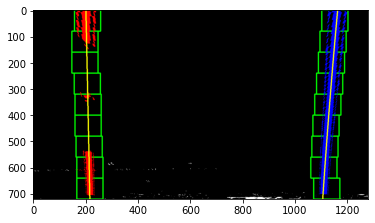

[-1.94254046e-06  2.23907927e-02  2.02102863e+02] [ 1.79903518e-05 -9.22125048e-02  1.16404559e+03]
48310.46 5217.1 11695.74
0.09


In [20]:
img = warp_binary_images[1]
line = Line()

diag_img = line.find_lane(img)
left_fit, right_fit = line.get_lane()
left_curv, right_curv, curv = line.get_curvature()
offset = line.get_offset()

plt.imshow(diag_img)
plt.show()
print(left_fit, right_fit)
print(left_curv, right_curv, curv)
print(offset)

In [21]:
"""
Draw drivable region, left and right lane on an image.
"""
def draw_region(undist, left_fit, right_fit):
    img_h = undist.shape[0]
    ploty = np.linspace(0, img_h-1, img_h)
    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    
    color_warp = np.zeros_like(undist)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane and drivable region onto the warped blank image
    cv2.polylines(color_warp, np.int_(pts_left), isClosed=False, color=(255,0,0), thickness=80)
    cv2.polylines(color_warp, np.int_(pts_right), isClosed=False, color=(17, 182, 19), thickness=80)
    cv2.fillPoly(color_warp, np.int_([pts]), (99, 65, 239))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result

In [22]:
"""
Put left, right curvature and average curvature and also the offset on an image
"""

def put_curvature_and_offset(result, left_curverad, right_curverad, curvature, offset):
    curv_str = 'Curve radius: ' + str(curvature) + 'm'
    offset_str = 'Car pos from center: ' + str(offset) + 'm'
    
    font = cv2.FONT_HERSHEY_DUPLEX
    scale = 1.2
    white = (255, 255, 255)
    thickness = 1
    cv2.putText(result, curv_str, (30, 60), font, scale, white, thickness)
    cv2.putText(result, offset_str, (30, 90), font, scale, white, thickness)
    
    return result

In [23]:
"""
Draw dirvable region on an image. Given a Line object.
"""
def annotate_image(undist, line):
    left_fit, right_fit = line.get_lane()
    left_curv, right_curv, curv = line.get_curvature()
    offset = line.get_offset()
    
    result = draw_region(undist, left_fit, right_fit)
    result = put_curvature_and_offset(result, left_curv, right_curv, curv, offset)
    return result

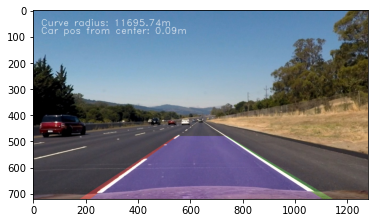

In [24]:
undist = undist_images[1]
result = annotate_image(undist, line)
plt.imshow(result)
plt.show()

# Image Processing Pipeline

We have all the components of the pipeline built out. Now, we need to combine them into a single pipeline that will run on video footage.

In [25]:
line = Line()
   
def debug_image(image, diagnosis=True):
    undist_img = cv2.undistort(image, mtx, dist, None, mtx)
    binary_img = combined_binary(undist_img)
    image_size = (image.shape[1], image.shape[0])
    warp_binary = cv2.warpPerspective(binary_img, M, image_size, cv2.INTER_LINEAR)
    diag_img = line.find_lane(warp_binary)
    result = annotate_image(undist_img, line)

    if diagnosis:
        # Calculate the size of screens
        result_screen_w = result.shape[1]
        result_screen_h = result.shape[0]
        diag_screen_w = np.int(result_screen_w / 3)
        diag_screen_h = np.int(result_screen_h / 3)
        screen_w = result_screen_w + diag_screen_w
        screen_h = result_screen_h
        # Assign result image to the screen
        screen = np.zeros((screen_h, screen_w, 3), dtype=np.uint8)
        screen[0:result_screen_h, 0:result_screen_w] = result
        # Assgin diagnosis image to the screen
        diag_img_1 = np.dstack((binary_img, binary_img, binary_img))*255
        screen[0:diag_screen_h, result_screen_w:, :] = cv2.resize(diag_img_1, (diag_screen_w, diag_screen_h))
        diag_img_2 = np.dstack((warp_binary, warp_binary, warp_binary))*255
        screen[diag_screen_h : diag_screen_h*2, result_screen_w:, :] = cv2.resize(diag_img_2, (diag_screen_w, diag_screen_h))
        screen[diag_screen_h*2 : diag_screen_h*3, result_screen_w:, :] = cv2.resize(diag_img, (diag_screen_w, diag_screen_h))
        return screen
    else: 
        return result
    
    

C:\Users\Public\Documents\iSkysoft\CreatorTemp\ipykernel_14380\1873375808.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0]/2)
C:\Users\Public\Documents\iSkysoft\CreatorTemp\ipykernel_14380\1873375808.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your cur

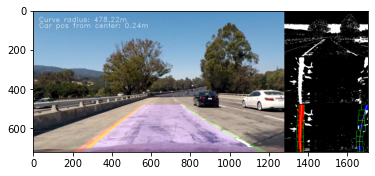

In [26]:
image = mpimg.imread('test_images/test1.jpg')
out = debug_image(image, diagnosis=True)
plt.imshow(out)
plt.show()

In [27]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [28]:
line = Line()

project_video_output = 'output_videos/project_video_out.mp4'
clip1 = VideoFileClip("test_videos/project_video.mp4")
Challange_clip = clip1.fl_image(debug_image) #NOTE: this function expects color images!!
%time Challange_clip.write_videofile(project_video_output, audio=False)

Moviepy - Building video output_videos/project_video_out.mp4.
Moviepy - Writing video output_videos/project_video_out.mp4



Moviepy - Done !
Moviepy - video ready output_videos/project_video_out.mp4
CPU times: total: 21min 29s
Wall time: 7min 27s


In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_output))

In [30]:
line = Line()

challenge_video_output = 'output_videos/challenge_video_out.mp4'
clip2 = VideoFileClip("test_videos/challenge_video.mp4")
Challange_clip = clip2.fl_image(debug_image) #NOTE: this function expects color images!!
%time Challange_clip.write_videofile(challenge_video_output, audio=False)

Moviepy - Building video output_videos/challenge_video_out.mp4.
Moviepy - Writing video output_videos/challenge_video_out.mp4



Moviepy - Done !
Moviepy - video ready output_videos/challenge_video_out.mp4
CPU times: total: 7min 55s
Wall time: 2min 35s


In [31]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_video_output))

In [32]:
line = Line()

harder_challenge_video_output = 'output_videos/harder_challenge_video_out.mp4'
clip3 = VideoFileClip("test_videos/harder_challenge_video.mp4")
Challange_clip = clip3.fl_image(debug_image) #NOTE: this function expects color images!!
%time Challange_clip.write_videofile(harder_challenge_video_output, audio=False)

Moviepy - Building video output_videos/harder_challenge_video_out.mp4.
Moviepy - Writing video output_videos/harder_challenge_video_out.mp4



Moviepy - Done !
Moviepy - video ready output_videos/harder_challenge_video_out.mp4
CPU times: total: 20min 30s
Wall time: 7min 1s


In [33]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_challenge_video_output))